In [1]:
import os
import open_clip
import torch
import numpy as np
from matplotlib import pyplot as plt

from dimensionality_recuction import pca
from utils import get_dataset, get_clip_features
from classify_images import ClipClassifier

In [2]:
# @title settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_name = 'ViT-B-32'
# pretrained_datset = 'laion2b_s34b_b79k'
model_name = 'RN50'
pretrained_datset = 'openai'

dataset_name = "STL10"
outputs_dir = os.path.join("outputs", f"{model_name}({pretrained_datset})")

# Load_model
model, _, preprocess = open_clip.create_model_and_transforms(model_name, pretrained=pretrained_datset, device=device, cache_dir='/mnt/storage_ssd/big_files')
model.preprocess = preprocess

dataset, label_map = get_dataset(dataset_name, model.preprocess, data_root='/mnt/storage_ssd/datasets', restrict_to_classes=['truck', 'deer'])


# Extract CLIP features
text_features, image_features, labels = get_clip_features(model, dataset, label_map, device,
                                                          os.path.join(outputs_dir, f"{dataset_name}_features"))

# PCA
PCs, eigv, mean = pca(np.concatenate((text_features, image_features)))
PCs, mean = torch.from_numpy(PCs), torch.from_numpy(mean)
text_pcs = (text_features - mean) @ PCs
image_pcs = (image_features - mean) @ PCs
# label_pcs = np.dot(classifier.label_features.cpu().numpy() - mean, PCs)


Files already downloaded and verified


In [3]:
import clip

class ClipPCClassifier:
    def __init__(self, model, dataset, PCs, mean):
        self.PCs = PCs.to(device)
        self.mean = mean.to(device)
        text_tokens = clip.tokenize([f"This is a photo of a {label}" for label in dataset.classes]).to(device)
        with torch.no_grad():
            label_features = model.encode_text(text_tokens).float()
            label_features /= label_features.norm(dim=-1, keepdim=True)
            label_features = label_features
            self.label_pcs = (label_features - self.mean) @ self.PCs
            
    def predict(self, features, return_probs=False, slice=None):
        embs = (features.to(device) - self.mean) @ self.PCs
        if slice is not None:
            logits = (embs[:, slice] @ self.label_pcs.T[slice]).softmax(1)
        else:
            logits = (embs @ self.label_pcs.T).softmax(1)
        if return_probs:
            return logits
        return logits.argmax(1).item()
    
classifier = ClipPCClassifier(model, dataset, PCs, mean)

/home/ariel/university/Internship/diffusion_venv/lib/python3.10/site-packages/torch/nn/modules/activation.py:1160: UserWarning: Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at ../aten/src/ATen/native/transformers/attention.cpp:150.)
  return torch._native_multi_head_attention(


In [4]:
from torch import optim
from PIL import Image
import cv2
import torchvision

def puttext(img, text, x, y):
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 4, cv2.LINE_AA)
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, (128, 128, 128), 2, cv2.LINE_AA)

def typographic_atack(img, text, n=3):   
    img = img.clone().cpu().numpy().transpose((1, 2, 0))
    img = img - img.min()
    img = img / img.max()
    img = np.ascontiguousarray(img * 255, dtype=np.uint8)

    texts = []
    dim = 224
    bbox_width = 50
    bbox_height = 30
    while len(texts) < n:
        x = np.random.randint(0, dim - bbox_width)
        y = np.random.randint(0, dim - bbox_height)
        
        # Check if this bbox intersects with any existing bbox in samples
        intersects = False
        for (sx, sy) in texts:
            if (x < sx + bbox_width and x + bbox_width > sx and
                y < sy + bbox_height and y + bbox_height > sy):
                intersects = True
                break
        
        if not intersects:
            puttext(img, text, x, y)
            texts.append((x, y))
    
    img = Image.fromarray(img)
    img = torchvision.transforms.ToTensor()(img)

    return img.unsqueeze(0).cuda()


def optimize_image(model, img, target_label, classifier, norm_coeff=0.01, lr=0.1, n_steps=100, pc_slice=None, verbose=False):
    y_goal = torch.tensor([target_label]).cuda()
    img = img.clone().cuda().unsqueeze(0)
    residue = torch.zeros_like(img) * 1e-4
    residue.requires_grad = True
    optimizer = optim.Adam([residue], lr=lr)
    best_img = None
    best_norm = np.inf
    for i in range(n_steps):
        features = model.encode_image(img + residue).float()
        features = features / features.norm(dim=-1, keepdim=True)
        if i == 0:
            org_pred = classifier.predict(features)

        logits = classifier.predict(features, return_probs=True, slice=pc_slice)
        # logits = classifier.predict(features, return_probs=True, slice=slice(1, 2))

        residue_norm = torch.norm(residue.view(len(residue), -1), dim=1).mean()

        loss = torch.nn.functional.nll_loss(logits, y_goal) + norm_coeff * residue_norm
        loss.backward()
        # residue.grad = residue.grad.sign()
        optimizer.step()
        residue.grad.zero_()
        
        # with torch.no_grad():
        #     residue = torch.clamp(residue, -0.1, 0.1)
        #     # residue = residue / residue.norm() * 5
        # residue.requires_grad = True
        with torch.no_grad():
            features = model.encode_image(img + residue).float()
            features = features / features.norm(dim=-1, keepdim=True)
            cur_pred = classifier.predict(features)
        if residue_norm.item() < best_norm and cur_pred != org_pred:
            best_img = (img + residue).detach()
            best_norm = residue_norm.item()


        if verbose or i  == n_steps - 1:
            print(f"iter: {i}, loss: {loss}, best norm: {best_norm}, norm: {residue_norm}, pred {org_pred}->{cur_pred}")

    return best_img, best_norm


def pred_and_get_pcs(x):
    with torch.no_grad():
        features = model.encode_image(x)
        features /= features.norm(dim=-1, keepdim=True)
        pcs = (features.cpu() - mean) @ PCs
        pred = classifier.predict(features)
    return pcs, pred

In [5]:
img, gt_label = dataset[np.random.randint(len(dataset))]
# img, gt_label = dataset[0]
target_label = np.random.choice([x for x in range(len(dataset.classes)) if x != gt_label])
print(gt_label, target_label, pred_and_get_pcs(img.unsqueeze(0).cuda())[1])
adv, adv_residue_norm = optimize_image(model, img, target_label, classifier, norm_coeff=0.01, lr=0.02, n_steps=400, pc_slice=None, verbose=False)
adv_pc2, adv_pc2_residue_norm = optimize_image(model, img, target_label, classifier, norm_coeff=0.1, lr=0.02, n_steps=400, pc_slice=slice(1,2), verbose=False)
adv_pc3_plus, adv_pc3_plus_residue_norm = optimize_image(model, img, target_label, classifier, norm_coeff=0.01, lr=0.02, n_steps=400, pc_slice=slice(2,None), verbose=False)

typo_output = typographic_atack(img, dataset.classes[target_label])

typo_output_2 = typographic_atack(torch.zeros_like(img), dataset.classes[target_label])

torchvision.utils.save_image(img, "outputs/img.png", normalize=True, scale_each=True)
torchvision.utils.save_image(adv, "outputs/adv.png", normalize=True, scale_each=True)
torchvision.utils.save_image(adv_pc2, "outputs/adv_pc2.png", normalize=True, scale_each=True)
torchvision.utils.save_image(adv_pc3_plus, "outputs/adv_pc3_plus.png", normalize=True, scale_each=True)
torchvision.utils.save_image(typo_output, "outputs/typo.png", normalize=True, scale_each=True)
torchvision.utils.save_image(typo_output_2, "outputs/typo_2.png", normalize=True, scale_each=True)

img_pcs, img_pred = pred_and_get_pcs(img.cuda().unsqueeze(0))
typo_pcs, typo_pred = pred_and_get_pcs(typo_output)
adv_pcs, adv_pred = pred_and_get_pcs(adv)
adv_pc2_pcs, adv_pc2_pred = pred_and_get_pcs(adv_pc2)
adv_pc3_plus_pcs, adv_pc3_plus_pred = pred_and_get_pcs(adv_pc3_plus)
typo_pcs_2, typo_pred_2 = pred_and_get_pcs(typo_output_2)

print("results:")
print(f"GT label: {dataset.classes[gt_label]}")
print(f"adv_pred: {dataset.classes[adv_pred]}, norm {adv_residue_norm}")
print(f"adv_pc2: {dataset.classes[adv_pc2_pred]}, norm {adv_pc2_residue_norm}")
print(f"adv_pc3_plus: {dataset.classes[adv_pc3_plus_pred]}, norm {adv_pc3_plus_residue_norm}")
print(f"typo_pred: {dataset.classes[typo_pred]}")
print(f"text_pred: {dataset.classes[typo_pred_2]}")

0 1 0
iter: 399, loss: -0.43262970447540283, best norm: 10.820573806762695, norm: 17.17465591430664, pred 0->1
iter: 399, loss: -0.053982436656951904, best norm: 2.924732208251953, norm: 4.917967796325684, pred 0->1
iter: 399, loss: -0.44277068972587585, best norm: 8.813435554504395, norm: 12.072476387023926, pred 0->1
results:
GT label: deer
adv_pred: truck, norm 10.820573806762695
adv_pc2: truck, norm 2.924732208251953
adv_pc3_plus: truck, norm 8.813435554504395
typo_pred: truck
text_pred: truck


/tmp/ipykernel_2359148/3175357480.py:13: RuntimeWarning: invalid value encountered in divide
  img = img / img.max()
/tmp/ipykernel_2359148/3175357480.py:14: RuntimeWarning: invalid value encountered in cast
  img = np.ascontiguousarray(img * 255, dtype=np.uint8)


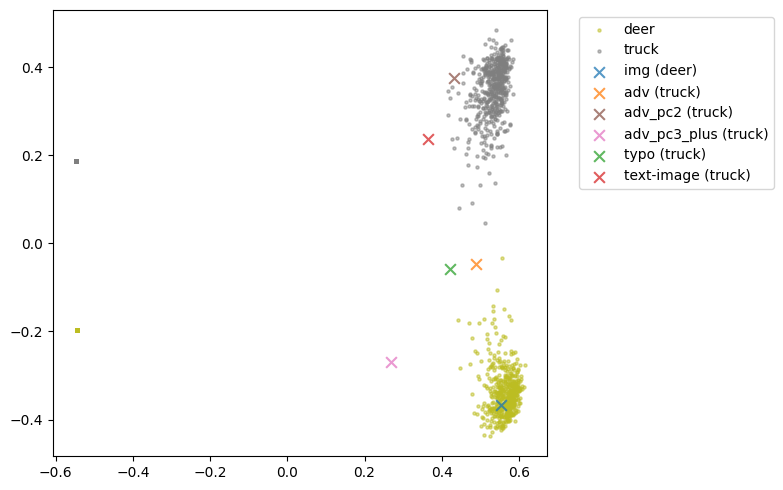

<Figure size 640x480 with 0 Axes>

In [6]:
cmap = plt.get_cmap('tab10')
n = len(dataset.classes) + 6
colors = [cmap(i/n) for i in range(n)]
fig = plt.figure(1, figsize=(8, 5))
ax = fig.add_subplot(111)
pc_1 = 0
pc_2 = 1
for label in np.unique(labels):
    idx = labels == label
    ax.scatter(text_pcs[idx, pc_1], text_pcs[idx, pc_2],
               color=colors[-label-1], label=dataset.classes[label], s=5, alpha=0.5)
    ax.scatter(image_pcs[idx, pc_1], image_pcs[idx, pc_2],
               color=colors[-label-1], s=5, alpha=0.5)

ax.scatter(img_pcs[:, pc_1], img_pcs[:, pc_2],
   color=colors[0], s=60, alpha=0.75, marker='x', label=f'img ({dataset.classes[gt_label]})')

ax.scatter(adv_pcs[:, pc_1], adv_pcs[:, pc_2],
   color=colors[1], s=60, alpha=0.75, marker='x', label=f'adv ({dataset.classes[adv_pred]})')

ax.scatter(adv_pc2_pcs[:, pc_1], adv_pc2_pcs[:, pc_2],
   color=colors[4], s=60, alpha=0.75, marker='x', label=f'adv_pc2 ({dataset.classes[adv_pc2_pred]})')
ax.scatter(adv_pc3_plus_pcs[:, pc_1], adv_pc3_plus_pcs[:, pc_2],
   color=colors[5], s=60, alpha=0.75, marker='x', label=f'adv_pc3_plus ({dataset.classes[adv_pc3_plus_pred]})')


ax.scatter(typo_pcs[:, pc_1], typo_pcs[:, pc_2],
   color=colors[2], s=60, alpha=0.75, marker='x', label=f'typo ({dataset.classes[typo_pred]})')

ax.scatter(typo_pcs_2[:, pc_1], typo_pcs_2[:, pc_2],
   color=colors[3], s=60, alpha=0.75, marker='x', label=f'text-image ({dataset.classes[typo_pred_2]})')
    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("outputs/fig.png")
plt.show()
plt.clf()


/tmp/ipykernel_2359148/3175357480.py:13: RuntimeWarning: invalid value encountered in divide
  img = img / img.max()
/tmp/ipykernel_2359148/3175357480.py:14: RuntimeWarning: invalid value encountered in cast
  img = np.ascontiguousarray(img * 255, dtype=np.uint8)


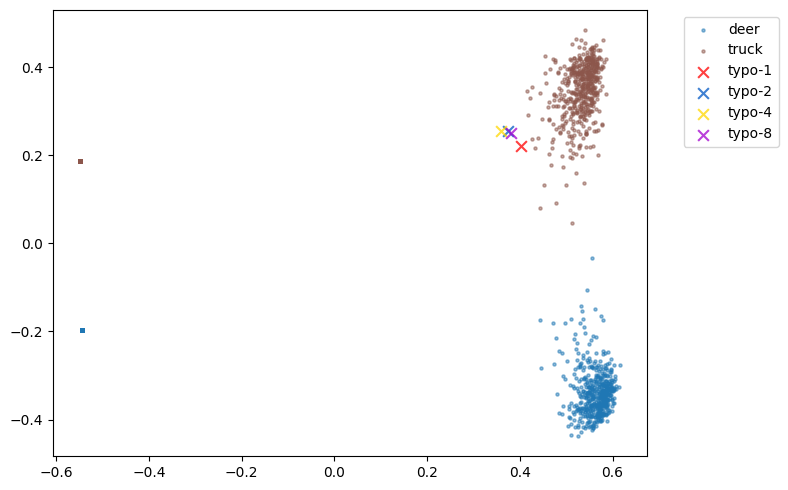

<Figure size 640x480 with 0 Axes>

In [7]:
# plot text space 
fig = plt.figure(1, figsize=(8, 5))
ax = fig.add_subplot(111)
pc_1 = 0
pc_2 = 1

colors = [cmap(i/2) for i in range(2)]
for label in np.unique(labels):
    idx = labels == label
    ax.scatter(text_pcs[idx, pc_1], text_pcs[idx, pc_2],
               color=colors[label], label=dataset.classes[label], s=5, alpha=0.5)
    ax.scatter(image_pcs[idx, pc_1], image_pcs[idx, pc_2],
               color=colors[label], s=5, alpha=0.5)
    
ns =  [1, 2, 4, 8]
cmap = plt.get_cmap('prism')
colors = [cmap(i/len(ns)) for i in range(len(ns))]
for i, n in enumerate(ns):
    typo_output_2 = typographic_atack(torch.zeros_like(img), dataset.classes[target_label], n=n)
    torchvision.utils.save_image(typo_output_2, f"outputs/empty_typo_{n}.png", normalize=True, scale_each=True)
    typo_pcs_2, typo_pred_2 = pred_and_get_pcs(typo_output_2)

    ax.scatter(typo_pcs_2[:, pc_1], typo_pcs_2[:, pc_2],
    color=colors[i], s=60, alpha=0.75, marker='x', label=f'typo-{n}')
    
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("outputs/fig_textspace.png")
plt.show()
plt.clf()